In [1]:
import numpy as np
import gym
env = gym.make("LunarLander-v2")
input_shape = env.observation_space.shape
n_outputs = env.action_space.n
input_shape, n_outputs

((8,), 4)

In [2]:
import tensorflow as tf
from tensorflow import keras

# model that predicts Q-value for each action according to an input state
print(env.reset()[np.newaxis, :])
print(env.action_space.n)
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=input_shape))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(n_outputs))
model(env.reset()[np.newaxis, :])
model_initial_weights = model.get_weights()

/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resam

[[-0.00235128  1.41873    -0.23818281  0.34710982  0.00273143  0.05395196
   0.          0.        ]]
4


2022-06-06 17:42:27.297143: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis, :])
        return np.argmax(Q_values[0])
epsilon_greedy_policy(env.reset())

3

In [4]:
from collections import deque

# el: state, action, reward, next_state, done
replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    experiences = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([exp[col] for exp in experiences]) for col in range(5)]
    return states, actions, rewards, next_states, dones

# replay_buffer = [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14]]
# sample_experiences(2)

In [5]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    obs, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, obs, done))
    return obs, reward, done, info

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [18:36<00:00,  1.49s/it]

-229.25300748502193 159.54499198576477 -979.0204995536682 30.976596239496246


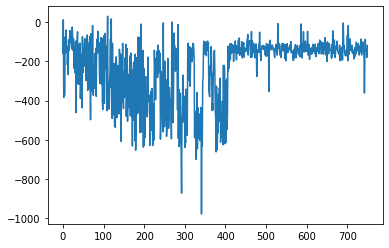

In [6]:
# training
from tqdm import tqdm
import matplotlib.pyplot as plt

batch_size = 32
discount_factor = 0.97
optimizer = keras.optimizers.Adam(0.001)
loss_fn = keras.losses.mean_squared_error
n_episodes = 750
n_steps = 200

def training_step(batch_size):
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states)
    max_next_Q_values = tf.reduce_max(next_Q_values, axis=1) # agent plays optimally => store only max values
    target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values
    mask = tf.one_hot(actions, n_outputs) 
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(mask * all_Q_values, axis=1, keepdims=True) # mask out q values for actions that were not chosen 
        loss = tf.reduce_mean(loss_fn(Q_values, target_Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

def train():
    episode_rewards = []
    for episode in tqdm(range(n_episodes)):
        obs = env.reset()
        step_reward = 0
        for step in range(n_steps):
            eps = max(1 - episode / 500, 0.01)
            obs, reward, done, info = play_one_step(env, obs, eps)
            step_reward += reward
            if done:
                break
        episode_rewards.append(step_reward)
        if episode > 50:
            training_step(batch_size)
    return episode_rewards
episode_rewards = train()
print(np.mean(episode_rewards), np.std(episode_rewards), np.min(episode_rewards), np.max(episode_rewards))
# -359.2941391120138 219.35082075916458 -1486.1583193369427 98.2295202449274 lr = 0.001
# -357.13935431215975 190.29114724718954 -1341.4294567761463 18.40714374846098 lr = 0.001
# -229.25300748502193 159.54499198576477 -979.0204995536682 30.976596239496246 lr = 0.0001

plt.plot(episode_rewards)

### DQN variants

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [21:53<00:00,  1.75s/it]

-341.1396816170447 230.44800002718998 -1636.5035406484951 64.52292098813788


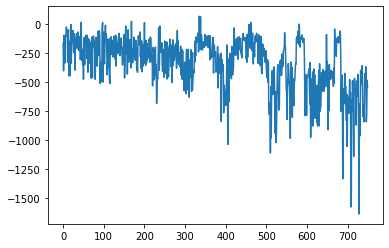

In [9]:
def fixed_q_value_targets():
    # target model is updated less often
    model.set_weights(model_initial_weights)
    target = keras.models.clone_model(model)
    target.set_weights(model.get_weights())
    def training_step_fixed_q_value_targets(batch_size):
        states, actions, rewards, next_states, dones = sample_experiences(batch_size)
        next_Q_values = target.predict(next_states)
        max_next_Q_values = tf.reduce_max(next_Q_values, axis=1) # agent plays optimally => store only max values
        target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values
        mask = tf.one_hot(actions, n_outputs) 
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(mask * all_Q_values, axis=1, keepdims=True) # mask out q values for actions that were not chosen 
            loss = tf.reduce_mean(loss_fn(Q_values, target_Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    def train_fixed_q_value_targets():
        episode_rewards = []
        for episode in tqdm(range(n_episodes)):
            obs = env.reset()
            step_reward = 0
            for step in range(n_steps):
                eps = max(1 - episode / 500, 0.01)
                obs, reward, done, info = play_one_step(env, obs, eps)
                step_reward += reward
                if done:
                    break
            episode_rewards.append(step_reward)
            if episode > 50:
                training_step_fixed_q_value_targets(batch_size)
            if episode % 50 == 0:
                target.set_weights(model.get_weights())
        return episode_rewards
    episode_rewards = train()
    print(np.mean(episode_rewards), np.std(episode_rewards), np.min(episode_rewards), np.max(episode_rewards))
    plt.plot(episode_rewards)
fixed_q_value_targets()
# -341.1396816170447 230.44800002718998 -1636.5035406484951 64.52292098813788 lr=0.0001

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [20:53<00:00,  1.67s/it]

-363.62281644615945 248.16990491345817 -1693.9193600041297 26.03544685309879


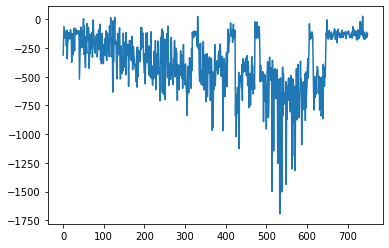

In [10]:
def double_dqn():
    # target model is updated less often
    model.set_weights(model_initial_weights)
    target = keras.models.clone_model(model)
    target.set_weights(model.get_weights())
    def training_step_double_dqn(batch_size):
        states, actions, rewards, next_states, dones = sample_experiences(batch_size)
        next_Q_values = model.predict(next_states) # in place of max_next_Q_values:
        best_next_actions = np.argmax(next_Q_values, axis=1) # use model to get the best actions
        next_mask = tf.one_hot(next_Q_values, n_outputs).numpy()
        next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1) #  use target to get next best Q values
        target_Q_values = rewards + (1 - dones) * discount_factor * next_best_Q_values
        mask = tf.one_hot(actions, n_outputs) 
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(mask * all_Q_values, axis=1, keepdims=True) # mask out q values for actions that were not chosen 
            loss = tf.reduce_mean(loss_fn(Q_values, target_Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    def train_double_dqn():
        episode_rewards = []
        for episode in tqdm(range(n_episodes)):
            obs = env.reset()
            step_reward = 0
            for step in range(n_steps):
                eps = max(1 - episode / 500, 0.01)
                obs, reward, done, info = play_one_step(env, obs, eps)
                step_reward += reward
                if done:
                    break
            episode_rewards.append(step_reward)
            if episode > 50:
                training_step_double_dqn(batch_size)
            if episode % 50 == 0:
                target.set_weights(model.get_weights())
        return episode_rewards
    episode_rewards = train()
    print(np.mean(episode_rewards), np.std(episode_rewards), np.min(episode_rewards), np.max(episode_rewards))
    plt.plot(episode_rewards)
double_dqn()
# -363.62281644615945 248.16990491345817 -1693.9193600041297 26.03544685309879 lr=0.0001

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [20:22<00:00,  1.63s/it]

-239.18395713591755 195.1181414071105 -1206.7223045941644 47.84905991382061


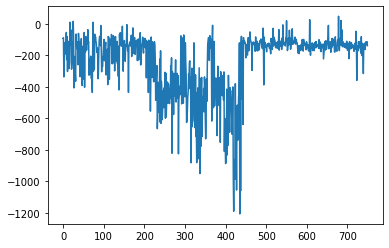

In [15]:
def dueling_dqn():
    # dueling + double dqn
    def build_model():
        input_states = keras.Input(shape=input_shape)
        hidden1 = keras.layers.Dense(64, activation='relu')(input_states)
        hidden2 = keras.layers.Dense(32, activation='relu')(hidden1)
        state_values = keras.layers.Dense(1)(hidden2)
        raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
        advantages = raw_advantages - tf.reduce_mean(raw_advantages, axis=1, keepdims=True)
        Q_values = state_values + advantages
        return keras.Model(inputs=[input_states], outputs=[Q_values])
    model = build_model()
    target = keras.models.clone_model(model)
    target.set_weights(model.get_weights())
    def training_step_double_dqn(batch_size):
        states, actions, rewards, next_states, dones = sample_experiences(batch_size)
        next_Q_values = model.predict(next_states) # in place of max_next_Q_values:
        best_next_actions = np.argmax(next_Q_values, axis=1) # use model to get the best actions
        next_mask = tf.one_hot(next_Q_values, n_outputs).numpy()
        next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1) #  use target to get next best Q values
        target_Q_values = rewards + (1 - dones) * discount_factor * next_best_Q_values
        mask = tf.one_hot(actions, n_outputs) 
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(mask * all_Q_values, axis=1, keepdims=True) # mask out q values for actions that were not chosen 
            loss = tf.reduce_mean(loss_fn(Q_values, target_Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    def train_double_dqn():
        episode_rewards = []
        for episode in tqdm(range(n_episodes)):
            obs = env.reset()
            step_reward = 0
            for step in range(n_steps):
                eps = max(1 - episode / 500, 0.01)
                obs, reward, done, info = play_one_step(env, obs, eps)
                step_reward += reward
                if done:
                    break
            episode_rewards.append(step_reward)
            if episode > 50:
                training_step_double_dqn(batch_size)
            if episode % 50 == 0:
                target.set_weights(model.get_weights())
        return episode_rewards
    episode_rewards = train()
    print(np.mean(episode_rewards), np.std(episode_rewards), np.min(episode_rewards), np.max(episode_rewards))
    plt.plot(episode_rewards)
dueling_dqn()